In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import ModelCheckpoint

In [5]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [6]:
from PIL import Image
print(Image.__file__)

c:\Users\LEGION\anaconda3\envs\python310\lib\site-packages\PIL\Image.py


In [7]:
import Image
print(Image.__file__)

c:\Users\LEGION\anaconda3\envs\python310\lib\site-packages\PIL\Image.py


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# scale_datagen = ImageDataGenerator(rescale=1./255,
#                                    validation_split=0.3)

scale_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# train_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\Augmented"
# # train_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Augmented'
# # val_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Split/val'
# # test_dir = '/content/drive/MyDrive/Colab Skripsi/DATASETNEW/2_Split/test'


train_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\Data Train Gabungan"
val_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\Data Val Gabungan"
test_dir = r"D:\PROJECT\2_COMPUTER VISION\Image Segmentation\SPLIT\test"

In [11]:
train_generator = scale_datagen.flow_from_directory(
    train_dir,
    # subset='training',
    target_size=(224, 224),
    batch_size=40,
    class_mode='categorical'
)

Found 20412 images belonging to 4 classes.


In [12]:
val_generator = scale_datagen.flow_from_directory(
    val_dir,
    # subset='validation',
    target_size=(224, 224),
    batch_size=40,
    class_mode='categorical'
)

Found 5823 images belonging to 4 classes.


In [13]:
test_generator = scale_datagen.flow_from_directory(
    test_dir,
    # subset='validation',
    target_size=(224, 224),
    batch_size=40,
    class_mode='categorical'
)

Found 327 images belonging to 4 classes.


In [14]:
print(len(train_generator))
print(len(val_generator))
print(len(test_generator))

511
146
9


In [15]:
# jadi ini modelnya kek gausah bikin dari nol lagi tapi pake arsitektur yang udah ada

from keras.applications import vgg16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model

# SET DIMENSI INPUTNYA
img_rows, img_cols = 224, 224

# model learningnya based on imagenet dataset jadi weightnya set ke imagenet
# top layer diganti soalnya outputnya ada 20k neuron, tapi kita cuma butuh 2 neuron soalnya outputnya kan cuma 2, yes sama no
# ini download model yang udah ada jadi pake model vgg16
vgg = vgg16.VGG16(weights = "imagenet",
                  include_top = False,
                  input_shape = (img_rows, img_cols, 3))

# Ngefreeze 4 layer terkahir
# Layers yang di set ke trainable defaultnya True

for layer in vgg.layers:
  layer.trainable = False

# ngeprint semua layernya
for (i, layer) in enumerate(vgg.layers):
  print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [16]:
# tambahin beberapa layer ke model itu tadi

def lw(bottom_model, num_classes):
  """"creates the top or head of the model that will be
  placed ontop of the bottom layers"""

  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation="relu")(top_model)
  top_model = Dense(1024,activation="relu")(top_model)
  top_model = Dense(512,activation="relu")(top_model)
  top_model = Dense(num_classes,activation='softmax')(top_model) #last output layer, number of classes = 4
  return top_model

In [17]:
# itu tadi udah dibikin function lw nya, secara function lwnya di call

# jumlah class nya 2 soalnya yes sama no
num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])


learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# training mulai
filepath=r'D:\PROJECT\SKRIPSI\skripsi_vgg16_0005_augment_1.model.keras'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=(val_generator),
                    initial_epoch=0,
                    callbacks=[checkpoint])


# # training mulai

# history = model.fit(train_generator,
#                     epochs=10,
#                     validation_data=(val_generator),
#                     verbose = 1,
#                     initial_epoch=0)

Epoch 1/30
511/511 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.7955
Epoch 1: val_accuracy improved from -inf to 0.87275, saving model to D:\PROJECT\SKRIPSI\skripsi_vgg16_0005_augment_1.model.keras
511/511 [==============================] - 808s 2s/step - loss: 0.5068 - accuracy: 0.7955 - val_loss: 0.3170 - val_accuracy: 0.8727
Epoch 2/30
511/511 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.8852
Epoch 2: val_accuracy improved from 0.87275 to 0.91516, saving model to D:\PROJECT\SKRIPSI\skripsi_vgg16_0005_augment_1.model.keras
511/511 [==============================] - 266s 521ms/step - loss: 0.2915 - accuracy: 0.8852 - val_loss: 0.2358 - val_accuracy: 0.9152
Epoch 3/30
511/511 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.9019
Epoch 3: val_accuracy did not improve from 0.91516
511/511 [==============================] - 214s 419ms/step - loss: 0.2508 - accuracy: 0.9019 - val_loss: 0.2925 - val_accuracy: 0.893

In [20]:
# SAVE MODEL
save_path = r"D:\PROJECT\SKRIPSI\skripsi_vgg16_0005_augment_1.h5"
model.save(save_path)

In [21]:
# SAVE MODEL
weights_path = r"D:\PROJECT\SKRIPSI\skripsi_vgg16_0005_augment_1_weights.h5"
model.save_weights(weights_path)

EVALUASI

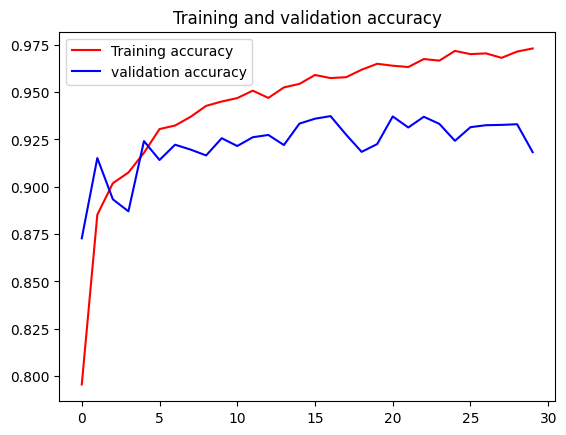

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

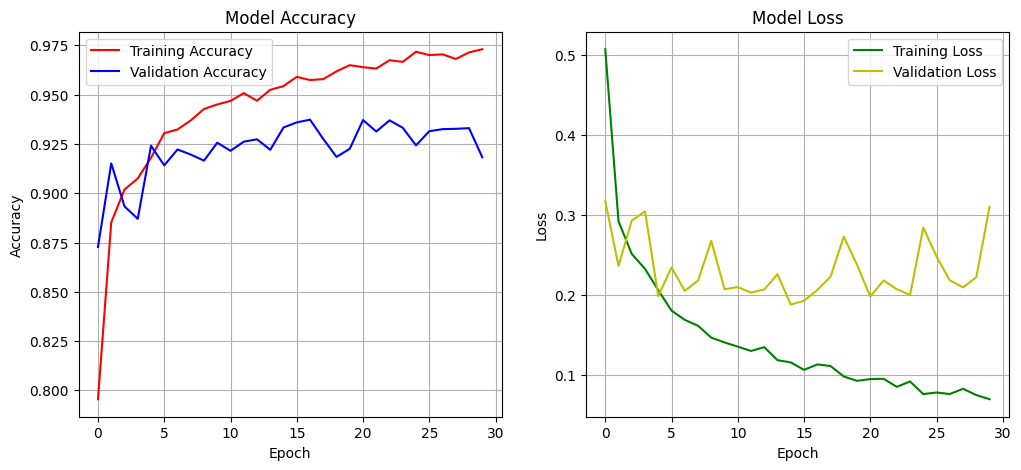

In [23]:
# Grafik plot value accuracy training sama validation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik plot value loss training sama validation
plt.subplot(1, 2, 2)
plt.plot(loss, 'g', label='Training Loss')
plt.plot(val_loss, 'y', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [24]:
from tensorflow import keras

model = keras.models.load_model("skripsi_vgg16_0005_augment_1.h5")

In [25]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 40

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",  # Change to 'categorical' if multi-class
    shuffle=False
)

true_labels = test_generator.classes


Found 327 images belonging to 4 classes.


In [26]:
pred_probs = model.predict(test_generator)

pred_labels = np.argmax(pred_probs, axis=1)


9/9 [==============================] - 8s 897ms/step


In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[96  2  0  1]
 [ 0 95  0  1]
 [ 3  1 75  1]
 [ 4  1  0 47]]


In [28]:
from sklearn.metrics import classification_report, accuracy_score

class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_labels, digits=4))

# akurasi
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

   EarlyPreB     0.9320    0.9697    0.9505        99
        PreB     0.9596    0.9896    0.9744        96
        ProB     1.0000    0.9375    0.9677        80
      benign     0.9400    0.9038    0.9216        52

    accuracy                         0.9572       327
   macro avg     0.9579    0.9502    0.9535       327
weighted avg     0.9580    0.9572    0.9571       327

Accuracy: 0.9572


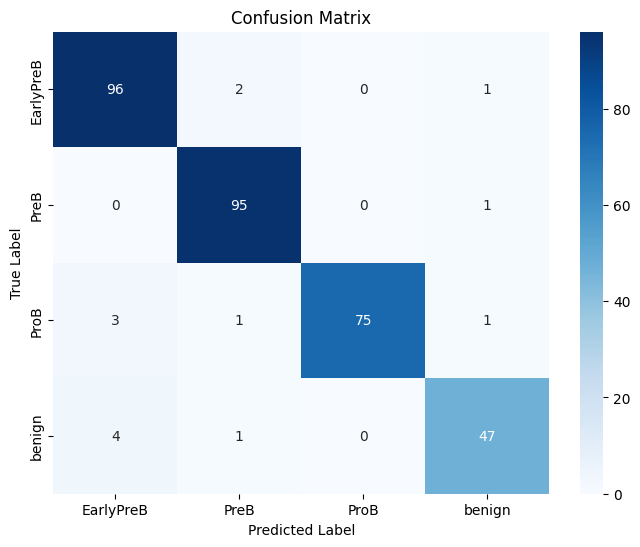

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
